<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Carga-de-los-datos" data-toc-modified-id="Carga-de-los-datos-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Carga de los datos</a></span></li><li><span><a href="#Entregable" data-toc-modified-id="Entregable-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Entregable</a></span><ul class="toc-item"><li><span><a href="#Análisis-de-los-datos" data-toc-modified-id="Análisis-de-los-datos-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Análisis de los datos</a></span></li><li><span><a href="#Split-data" data-toc-modified-id="Split-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Split data</a></span></li><li><span><a href="#Parametros-del-modelo" data-toc-modified-id="Parametros-del-modelo-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Parametros del modelo</a></span></li><li><span><a href="#Definicion-del-modelo-inicial" data-toc-modified-id="Definicion-del-modelo-inicial-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Definicion del modelo inicial</a></span></li><li><span><a href="#Graficas-del-modelo" data-toc-modified-id="Graficas-del-modelo-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Graficas del modelo</a></span></li><li><span><a href="#Mejoras-del-modelo:-más-capas-convolucionales" data-toc-modified-id="Mejoras-del-modelo:-más-capas-convolucionales-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Mejoras del modelo: más capas convolucionales</a></span></li><li><span><a href="#Data-augmentation" data-toc-modified-id="Data-augmentation-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Data augmentation</a></span></li></ul></li></ul></div>

# Laboratorio: Convolutional Neural Networks

En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [44]:
import cv2
import os
import numpy as np 
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer, Conv2D, MaxPooling2D, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import glob

In [45]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[22. 28.]
 [49. 64.]]


In [46]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="/home/diicic/master/SCART/simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /home/diicic/master/SCART/simpsons_train.tar.gz -C /home/diicic/master/SCART/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="/home/diicic/master/SCART/simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /home/diicic/master/SCART/simpsons_test.tar.gz -C /home/diicic/master/SCART/datasets

In [47]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [48]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [49]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [50]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/home/diicic/master/SCART/datasets/simpsons/"
DATASET_TEST_PATH_COLAB = "/home/diicic/master/SCART/datasets/simpsons_testset/"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [51]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

### Análisis de los datos

In [52]:
print("Tamaño y número de muestras de las imagenes")

img_width = X.shape[1]
img_height = X.shape[2]

print("Tenemos ", X.shape[0], 
      "imágenes de tamaño ",img_width, 
      "X", img_height,
     "en RGB (", X.shape[3],
      "capas)")

print("Hay que separar los datos en:", round(18992*0.8), 
      "imágenes de train y",round(18992*0.2), 
      "Imágenes de validation.")

Tamaño y número de muestras de las imagenes
Tenemos  18992 imágenes de tamaño  64 X 64 en RGB ( 3 capas)
Hay que separar los datos en: 15194 imágenes de train y 3798 Imágenes de validation.


### Split data

In [53]:
#Conjuntos de entrada
X_v = X[15194:]
X = X[:15194]

#Clasificaciones
y_v = y[15194:]
y = y[:15194]

print(X.shape)
print(X_v.shape)
print(X_t.shape)

print(y.shape)
print(y_v.shape)
print(y_t.shape)

(15194, 64, 64, 3)
(3798, 64, 64, 3)
(890, 64, 64, 3)
(15194,)
(3798,)
(890,)


### Parametros del modelo

In [54]:
from keras.optimizers import SGD,Adam,RMSprop
from keras.utils import np_utils

In [55]:
VALIDATION_SPLIT=0.2
BATCH_SIZE=128
NB_CLASSES=18
VERBOSE=1
NB_EPOCH = 20
OPTIM=RMSprop()

#convierto a categoricas
y=np_utils.to_categorical(y,NB_CLASSES)
y_t=np_utils.to_categorical(y_t,NB_CLASSES)
y_v=np_utils.to_categorical(y_v,NB_CLASSES)


#float and normalization
X=X.astype('float32')
X_t=X_t.astype('float32')
X/=255
X_t/=255


In [56]:
#Early Stopping y auto tune del Learning rate.
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                              factor=0.0001,
                              patience=5, 
                              min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_acc', 
                           min_delta=0, 
                           patience=10,
                           verbose=0, 
                           mode='auto', 
                           baseline=None, 
                           #restore_best_weights=False #Actualizar keras a 2.2.3
                          )

### Definicion del modelo inicial

In [57]:
#network
IMG_ROWS=64
IMG_COLS=64
IMG_CHANNELS=3
model=Sequential()
model.add(Conv2D(32,(3,3),padding='same',input_shape=(IMG_ROWS,IMG_COLS,IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(18))
model.add(Activation('softmax'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_11 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               16777728  
_________________________________________________________________
activation_12 (Activation)   (None, 512)               0         
__________

In [58]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [59]:
history1 = model.fit(X, y,
                     batch_size=BATCH_SIZE,
                     callbacks=[reduce_lr, early_stop],
                     epochs=500,
                     verbose=1,
                     validation_data=(X_v, y_v))

Train on 15194 samples, validate on 3798 samples
Epoch 1/500
15194/15194 [==============================] - 3s 195us/step - loss: 2.4454 - acc: 0.2705 - val_loss: 9.1928 - val_acc: 0.4213
Epoch 2/500
15194/15194 [==============================] - 2s 151us/step - loss: 1.7486 - acc: 0.4793 - val_loss: 8.3836 - val_acc: 0.4729
Epoch 3/500
15194/15194 [==============================] - 2s 160us/step - loss: 1.4276 - acc: 0.5790 - val_loss: 7.9491 - val_acc: 0.4995
Epoch 4/500
15194/15194 [==============================] - 2s 151us/step - loss: 1.2207 - acc: 0.6371 - val_loss: 7.5006 - val_acc: 0.5292
Epoch 5/500
15194/15194 [==============================] - 2s 155us/step - loss: 1.0402 - acc: 0.6936 - val_loss: 7.8031 - val_acc: 0.5092
Epoch 6/500
15194/15194 [==============================] - 2s 160us/step - loss: 0.8997 - acc: 0.7304 - val_loss: 7.6183 - val_acc: 0.5216
Epoch 7/500
15194/15194 [==============================] - 3s 191us/step - loss: 0.7782 - acc: 0.7608 - val_loss: 7.6

### Graficas del modelo


In [60]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    
    

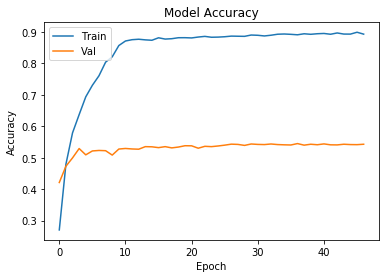

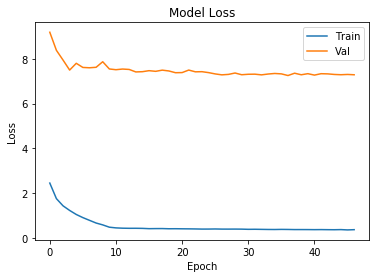

In [61]:
#muestro la accuracy del modelo
plot_acc(history1, title="Model Accuracy")
#muestro la loss del modelo
plot_loss(history1, title="Model Loss")

In [74]:
score=model.evaluate(X_t,y_t,batch_size=BATCH_SIZE,verbose=VERBOSE)

890/890 [==============================] - 0s 45us/step


In [75]:
print("Test score:", score[0])

Test score: 0.37376905291268


In [76]:
print("Test accuracy:", score[1])

Test accuracy: 0.9101123566038153


### Mejoras del modelo: más capas convolucionales

In [104]:
IMG_ROWS=64
IMG_COLS=64
IMG_CHANNELS=3

def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_ROWS,IMG_COLS,IMG_CHANNELS)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(18))
    model.add(Activation('sigmoid'))
    return model

In [105]:
model2 = createModel()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 31, 31, 64)        18496     
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 14, 14, 64)        0         
__________

In [106]:
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [107]:
VALIDATION_SPLIT=0.2
BATCH_SIZE=128
VERBOSE=1
NB_EPOCH = 100

history2 = model2.fit(X, y,
                     batch_size=BATCH_SIZE,
                     epochs=NB_EPOCH,
                     callbacks=[reduce_lr],# early_stop],
                     validation_split=VALIDATION_SPLIT,
                     verbose=VERBOSE)

Train on 12155 samples, validate on 3039 samples
Epoch 1/100
12155/12155 [==============================] - 3s 283us/step - loss: 2.8424 - acc: 0.0975 - val_loss: 2.8252 - val_acc: 0.1135
Epoch 2/100
12155/12155 [==============================] - 3s 224us/step - loss: 2.7080 - acc: 0.1365 - val_loss: 2.4645 - val_acc: 0.2185
Epoch 3/100
12155/12155 [==============================] - 3s 225us/step - loss: 2.4330 - acc: 0.2267 - val_loss: 2.1221 - val_acc: 0.3100
Epoch 4/100
12155/12155 [==============================] - 3s 239us/step - loss: 2.1654 - acc: 0.3030 - val_loss: 1.7760 - val_acc: 0.4070
Epoch 5/100
12155/12155 [==============================] - 3s 225us/step - loss: 1.8786 - acc: 0.3901 - val_loss: 1.5411 - val_acc: 0.4886
Epoch 6/100
12155/12155 [==============================] - 3s 222us/step - loss: 1.6496 - acc: 0.4686 - val_loss: 1.2554 - val_acc: 0.6124
Epoch 7/100
12155/12155 [==============================] - 3s 233us/step - loss: 1.4608 - acc: 0.5380 - val_loss: 1.0

12155/12155 [==============================] - 3s 228us/step - loss: 0.1343 - acc: 0.9562 - val_loss: 0.3471 - val_acc: 0.9243
Epoch 60/100
12155/12155 [==============================] - 3s 239us/step - loss: 0.1291 - acc: 0.9579 - val_loss: 0.3490 - val_acc: 0.9250
Epoch 61/100
12155/12155 [==============================] - 3s 236us/step - loss: 0.1277 - acc: 0.9580 - val_loss: 0.3509 - val_acc: 0.9243
Epoch 62/100
12155/12155 [==============================] - 3s 245us/step - loss: 0.1237 - acc: 0.9599 - val_loss: 0.3520 - val_acc: 0.9233
Epoch 63/100
12155/12155 [==============================] - 3s 226us/step - loss: 0.1302 - acc: 0.9573 - val_loss: 0.3522 - val_acc: 0.9243
Epoch 64/100
12155/12155 [==============================] - 3s 238us/step - loss: 0.1283 - acc: 0.9587 - val_loss: 0.3537 - val_acc: 0.9243
Epoch 65/100
12155/12155 [==============================] - 3s 232us/step - loss: 0.1275 - acc: 0.9587 - val_loss: 0.3536 - val_acc: 0.9237
Epoch 66/100
12155/12155 [=======

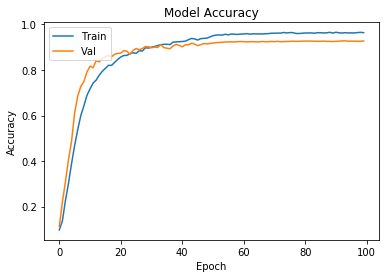

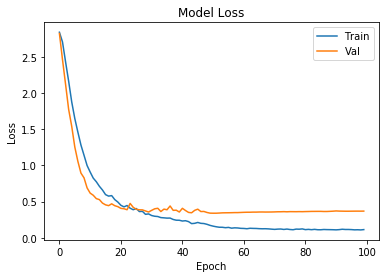

In [108]:
#muestro la accuracy del modelo
plot_acc(history2, title="Model Accuracy")
#muestro la loss del modelo
plot_loss(history2, title="Model Loss")

In [109]:
score=model2.evaluate(X_t, y_t, batch_size=BATCH_SIZE, verbose=VERBOSE)

890/890 [==============================] - 0s 89us/step


In [110]:
print("Test score:", score[0])
print("Test accuracy:", score[1])

Test score: 0.17136464249551966
Test accuracy: 0.9662921375103211


### Data augmentation

In [111]:
from keras.preprocessing.image import ImageDataGenerator
 
ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=1.,
    horizontal_flip=True,
    vertical_flip=True)

In [116]:

model3 = createModel()
 
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 256
epochs = 500
datagen = ImageDataGenerator(
#         zoom_range=0.2, # randomly zoom into images
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
 
# Fit the model on the batches generated by datagen.flow().
history3 = model3.fit_generator(datagen.flow(X, y, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(X_t.shape[0] / float(batch_size))),
                              epochs=epochs,
                              validation_data=(X_v, y_v),
                              workers=4)
 
model2.evaluate(X_t, y_t)

Epoch 1/500
4/4 [==============================] - 2s 389ms/step - loss: 2.8706 - acc: 0.0801 - val_loss: 5.7568 - val_acc: 0.0677
Epoch 2/500
4/4 [==============================] - 0s 107ms/step - loss: 2.8612 - acc: 0.0928 - val_loss: 5.1493 - val_acc: 0.0677
Epoch 3/500
4/4 [==============================] - 0s 108ms/step - loss: 2.8447 - acc: 0.1016 - val_loss: 5.9261 - val_acc: 0.0677
Epoch 4/500
4/4 [==============================] - 0s 111ms/step - loss: 2.8289 - acc: 0.1016 - val_loss: 4.8534 - val_acc: 0.0700
Epoch 5/500
4/4 [==============================] - 0s 106ms/step - loss: 2.8238 - acc: 0.1084 - val_loss: 4.7606 - val_acc: 0.0595
Epoch 6/500
4/4 [==============================] - 0s 109ms/step - loss: 2.8344 - acc: 0.0938 - val_loss: 4.7583 - val_acc: 0.0650
Epoch 7/500
4/4 [==============================] - 0s 111ms/step - loss: 2.8231 - acc: 0.0977 - val_loss: 4.7734 - val_acc: 0.0677
Epoch 8/500
4/4 [==============================] - 0s 120ms/step - loss: 2.8130 - a

4/4 [==============================] - 0s 105ms/step - loss: 2.2590 - acc: 0.2637 - val_loss: 6.6034 - val_acc: 0.1685
Epoch 64/500
4/4 [==============================] - 0s 106ms/step - loss: 2.2447 - acc: 0.2695 - val_loss: 7.4825 - val_acc: 0.1651
Epoch 65/500
4/4 [==============================] - 0s 107ms/step - loss: 2.3037 - acc: 0.2588 - val_loss: 5.8116 - val_acc: 0.1732
Epoch 66/500
4/4 [==============================] - 0s 104ms/step - loss: 2.2684 - acc: 0.2627 - val_loss: 6.6427 - val_acc: 0.1643
Epoch 67/500
4/4 [==============================] - 0s 104ms/step - loss: 2.1982 - acc: 0.3066 - val_loss: 6.3280 - val_acc: 0.1667
Epoch 68/500
4/4 [==============================] - 0s 105ms/step - loss: 2.2041 - acc: 0.2900 - val_loss: 7.0552 - val_acc: 0.1767
Epoch 69/500
4/4 [==============================] - 0s 103ms/step - loss: 2.1946 - acc: 0.3086 - val_loss: 6.7641 - val_acc: 0.1825
Epoch 70/500
4/4 [==============================] - 0s 104ms/step - loss: 2.2166 - acc: 0

Epoch 125/500
4/4 [==============================] - 0s 105ms/step - loss: 1.5461 - acc: 0.5215 - val_loss: 6.4539 - val_acc: 0.3660
Epoch 126/500
4/4 [==============================] - 0s 103ms/step - loss: 1.5390 - acc: 0.5234 - val_loss: 6.0612 - val_acc: 0.3670
Epoch 127/500
4/4 [==============================] - 0s 103ms/step - loss: 1.5653 - acc: 0.5137 - val_loss: 7.2588 - val_acc: 0.2694
Epoch 128/500
4/4 [==============================] - 0s 107ms/step - loss: 1.5496 - acc: 0.5186 - val_loss: 6.7869 - val_acc: 0.3220
Epoch 129/500
4/4 [==============================] - 0s 118ms/step - loss: 1.6689 - acc: 0.4902 - val_loss: 6.2443 - val_acc: 0.3589
Epoch 130/500
4/4 [==============================] - 0s 105ms/step - loss: 1.5896 - acc: 0.5000 - val_loss: 7.0755 - val_acc: 0.3594
Epoch 131/500
4/4 [==============================] - 0s 124ms/step - loss: 1.5368 - acc: 0.5127 - val_loss: 6.6155 - val_acc: 0.3555
Epoch 132/500
4/4 [==============================] - 0s 107ms/step - 

4/4 [==============================] - 0s 120ms/step - loss: 1.1379 - acc: 0.6504 - val_loss: 1.9396 - val_acc: 0.2612
Epoch 187/500
4/4 [==============================] - 0s 124ms/step - loss: 1.1082 - acc: 0.6650 - val_loss: 2.9738 - val_acc: 0.3102
Epoch 188/500
4/4 [==============================] - 1s 129ms/step - loss: 1.1940 - acc: 0.6133 - val_loss: 2.3522 - val_acc: 0.3023
Epoch 189/500
4/4 [==============================] - 0s 123ms/step - loss: 1.1342 - acc: 0.6377 - val_loss: 1.6384 - val_acc: 0.2199
Epoch 190/500
4/4 [==============================] - 0s 105ms/step - loss: 1.1428 - acc: 0.6426 - val_loss: 2.7658 - val_acc: 0.2199
Epoch 191/500
4/4 [==============================] - 0s 125ms/step - loss: 1.1271 - acc: 0.6562 - val_loss: 2.3885 - val_acc: 0.2391
Epoch 192/500
4/4 [==============================] - 0s 120ms/step - loss: 1.2392 - acc: 0.6182 - val_loss: 2.0927 - val_acc: 0.2754
Epoch 193/500
4/4 [==============================] - 0s 115ms/step - loss: 1.1038 -

Epoch 248/500
4/4 [==============================] - 0s 102ms/step - loss: 0.8539 - acc: 0.7168 - val_loss: 1.0053 - val_acc: 0.2088
Epoch 249/500
4/4 [==============================] - 0s 109ms/step - loss: 0.8738 - acc: 0.7266 - val_loss: 0.8544 - val_acc: 0.1669
Epoch 250/500
4/4 [==============================] - 0s 107ms/step - loss: 0.8447 - acc: 0.7236 - val_loss: 1.1871 - val_acc: 0.1940
Epoch 251/500
4/4 [==============================] - 0s 110ms/step - loss: 0.8656 - acc: 0.7373 - val_loss: 0.9912 - val_acc: 0.1827
Epoch 252/500
4/4 [==============================] - 0s 108ms/step - loss: 0.8554 - acc: 0.7441 - val_loss: 0.7557 - val_acc: 0.1572
Epoch 253/500
4/4 [==============================] - 0s 104ms/step - loss: 0.8872 - acc: 0.7100 - val_loss: 0.7661 - val_acc: 0.1675
Epoch 254/500
4/4 [==============================] - 0s 103ms/step - loss: 0.8283 - acc: 0.7422 - val_loss: 1.1304 - val_acc: 0.1933
Epoch 255/500
4/4 [==============================] - 0s 104ms/step - 

4/4 [==============================] - 0s 110ms/step - loss: 0.7843 - acc: 0.7510 - val_loss: 0.9071 - val_acc: 0.1833
Epoch 310/500
4/4 [==============================] - 0s 111ms/step - loss: 0.7451 - acc: 0.7686 - val_loss: 0.8426 - val_acc: 0.1524
Epoch 311/500
4/4 [==============================] - 0s 108ms/step - loss: 0.7829 - acc: 0.7617 - val_loss: 0.6025 - val_acc: 0.1693
Epoch 312/500
4/4 [==============================] - 0s 109ms/step - loss: 0.8682 - acc: 0.7588 - val_loss: 0.8805 - val_acc: 0.1643
Epoch 313/500
4/4 [==============================] - 0s 115ms/step - loss: 0.7645 - acc: 0.7764 - val_loss: 0.8989 - val_acc: 0.1546
Epoch 314/500
4/4 [==============================] - 0s 115ms/step - loss: 0.7593 - acc: 0.7617 - val_loss: 0.9091 - val_acc: 0.1511
Epoch 315/500
4/4 [==============================] - 0s 111ms/step - loss: 0.6745 - acc: 0.7971 - val_loss: 0.4845 - val_acc: 0.1506
Epoch 316/500
4/4 [==============================] - 0s 119ms/step - loss: 0.7074 -

Epoch 371/500
4/4 [==============================] - 0s 115ms/step - loss: 0.6392 - acc: 0.8115 - val_loss: 0.1769 - val_acc: 0.0885
Epoch 372/500
4/4 [==============================] - 0s 114ms/step - loss: 0.7090 - acc: 0.7695 - val_loss: 0.1613 - val_acc: 0.0890
Epoch 373/500
4/4 [==============================] - 0s 113ms/step - loss: 0.6560 - acc: 0.8115 - val_loss: 0.1570 - val_acc: 0.0893
Epoch 374/500
4/4 [==============================] - 0s 115ms/step - loss: 0.6166 - acc: 0.8008 - val_loss: 0.2334 - val_acc: 0.1064
Epoch 375/500
4/4 [==============================] - 0s 115ms/step - loss: 0.6144 - acc: 0.8069 - val_loss: 0.1698 - val_acc: 0.1008
Epoch 376/500
4/4 [==============================] - 0s 118ms/step - loss: 0.5978 - acc: 0.8154 - val_loss: 0.2249 - val_acc: 0.1066
Epoch 377/500
4/4 [==============================] - 0s 114ms/step - loss: 0.6160 - acc: 0.8066 - val_loss: 0.3683 - val_acc: 0.1159
Epoch 378/500
4/4 [==============================] - 0s 112ms/step - 

4/4 [==============================] - 0s 109ms/step - loss: 0.5935 - acc: 0.8164 - val_loss: 0.1188 - val_acc: 0.0779
Epoch 433/500
4/4 [==============================] - 0s 109ms/step - loss: 0.5617 - acc: 0.8330 - val_loss: 0.1698 - val_acc: 0.0922
Epoch 434/500
4/4 [==============================] - 0s 108ms/step - loss: 0.6392 - acc: 0.8027 - val_loss: 0.1146 - val_acc: 0.0848
Epoch 435/500
4/4 [==============================] - 0s 106ms/step - loss: 0.5246 - acc: 0.8366 - val_loss: 0.0880 - val_acc: 0.0769
Epoch 436/500
4/4 [==============================] - 0s 108ms/step - loss: 0.5601 - acc: 0.8330 - val_loss: 0.0849 - val_acc: 0.0782
Epoch 437/500
4/4 [==============================] - 0s 109ms/step - loss: 0.6000 - acc: 0.8252 - val_loss: 0.2504 - val_acc: 0.1014
Epoch 438/500
4/4 [==============================] - 0s 109ms/step - loss: 0.4970 - acc: 0.8389 - val_loss: 0.1188 - val_acc: 0.0874
Epoch 439/500
4/4 [==============================] - 0s 115ms/step - loss: 0.5264 -

Epoch 494/500
4/4 [==============================] - 0s 113ms/step - loss: 0.5201 - acc: 0.8525 - val_loss: 0.0764 - val_acc: 0.0753
Epoch 495/500
4/4 [==============================] - 1s 125ms/step - loss: 0.5012 - acc: 0.8517 - val_loss: 0.1041 - val_acc: 0.0827
Epoch 496/500
4/4 [==============================] - 0s 108ms/step - loss: 0.5112 - acc: 0.8359 - val_loss: 0.1317 - val_acc: 0.0787
Epoch 497/500
4/4 [==============================] - 0s 105ms/step - loss: 0.5060 - acc: 0.8408 - val_loss: 0.1320 - val_acc: 0.0795
Epoch 498/500
4/4 [==============================] - 0s 104ms/step - loss: 0.4707 - acc: 0.8555 - val_loss: 0.1273 - val_acc: 0.0882
Epoch 499/500
4/4 [==============================] - 0s 116ms/step - loss: 0.4380 - acc: 0.8496 - val_loss: 0.0891 - val_acc: 0.0816
Epoch 500/500
890/890 [==============================] - 0s 192us/step


[0.17136464743676144, 0.9662921348314607]

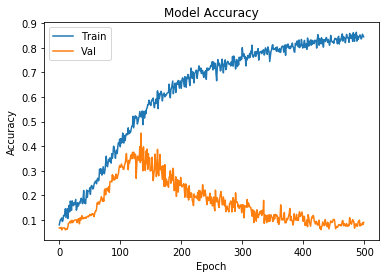

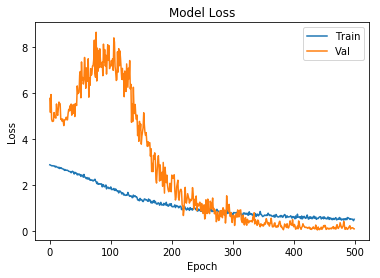

In [117]:
plot_acc(history3, title="Model Accuracy")
#muestro la loss del modelo
plot_loss(history3, title="Model Loss")

Overfitting a muerte.... Revisar.